In [1]:
!which pip

/home/mgross/anaconda3/envs/contrast-net/bin/pip


In [2]:
! nvidia-smi

Thu Jan 29 04:40:46 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                Off | 00000000:17:00.0 Off |                  Off |
| 33%   29C    P8              23W / 260W |   2118MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pytorch_lightning
from monai.visualize import img2tensorboard
import torch
import time
import sklearn

from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, \
    RandCropByPosNegLabeld, ToTensord,  \
    DataStatsd, AsDiscrete, KeepLargestConnectedComponent, RandFlipd
#LoadNiftid


from monai.data import list_data_collate
from monai.networks.layers import Norm

# from monai.metrics import compute_meandice
from monai.transforms import KeepLargestConnectedComponent

from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm





monai.config.print_config()

MONAI version: 0.7.0
Numpy version: 1.20.3
Pytorch version: 1.8.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfa054b9c3064628a21f4c35bbe3132964e91f43

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.3.1
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.2
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))


CUDA available:  True
GPU 0: Quadro RTX 8000


## Load the Data

In [5]:
INPUT_PATH = '../../ContrastNets.xlsx'
df = pd.read_excel(INPUT_PATH, index_col=False)
df.rename(columns= {'PRE': 'IMAGE'}, inplace = True)

In [6]:
df_train, df_val, df_test = \
              np.split(df.sample(frac=1, random_state=50), 
                       [int(.7*len(df)), int(.85*len(df))])


df_train['DATA_SPLIT'] = 'Train'
df_val['DATA_SPLIT'] = 'Val'
df_test['DATA_SPLIT'] = 'Test'


df = pd.concat([df_train, df_val, df_test])

In [7]:
# Convert DF to dictionary
train_data_dict = df_train.to_dict('records')
val_data_dict = df_val.to_dict('records')
test_data_dict = df_test.to_dict('records')

## Setup Input Transformations

In [10]:
SPACING = (2.0,2.0,2.0)
#PATCH_SIZE = (96,96,16)
PATCH_SIZE = (64,64,32)




train_transforms = Compose([
    LoadImaged(keys=['IMAGE', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('train_image','train_segm')),
    Spacingd(keys=['IMAGE', 'SEGM'], pixdim=SPACING, mode=('bilinear', 'nearest'), padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    SpatialPadd(keys=['IMAGE', 'SEGM'], spatial_size=PATCH_SIZE, mode=('reflect','reflect'), ),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('train_image','train_segm')),
    # randomly crop out patch samples from big image based on pos / neg ratio
    # the image centers of negative samples must be in valid image area
    RandCropByPosNegLabeld(keys=['IMAGE', 'SEGM'], label_key='SEGM', spatial_size=PATCH_SIZE, pos=3, neg=1, num_samples=2),
    RandFlipd(keys=['IMAGE', 'SEGM'], prob=0.5, spatial_axis=0),
    ToTensord(keys=['IMAGE', 'SEGM'])
])

val_transforms = Compose([
     LoadImaged(keys=['IMAGE', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
    Spacingd(keys=['IMAGE', 'SEGM'], pixdim=SPACING, mode=('bilinear', 'nearest'), padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),    
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['IMAGE', 'SEGM'])
])

test_transforms = Compose([
    LoadImaged(keys=['IMAGE', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
    Spacingd(keys=['IMAGE', 'SEGM'], pixdim=SPACING, mode=('bilinear', 'nearest'), padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['IMAGE', 'SEGM'])
])


inference_transforms = Compose([
     LoadImaged(keys=['IMAGE'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE']),
    Orientationd(keys=['IMAGE'], axcodes='RAS'),
    Spacingd(keys=['IMAGE'], pixdim=SPACING, mode=('bilinear'), padding_mode=('reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['IMAGE'])
])



## Create a Persistent Data Cache for Training and Validation Data

In [11]:
CACHE_PATH = '/tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-Net/monai_cache'


In [12]:
train_ds = monai.data.PersistentDataset(
    data=train_data_dict, transform=train_transforms, cache_dir=CACHE_PATH
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=list_data_collate)

In [13]:
val_ds = monai.data.PersistentDataset(
    data=val_data_dict, transform=val_transforms, cache_dir=CACHE_PATH
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

In [14]:
test_ds = monai.data.PersistentDataset(
    data=test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

## Check Input Data

torch.Size([1, 1, 181, 181, 110])
image shape: torch.Size([181, 181, 110]), label shape: torch.Size([181, 181, 110])
image mean: 0.46100932359695435


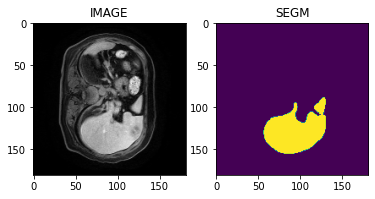

In [15]:
#check_ds = monai.data.Dataset(data=train_data_dict[:1], transform=train_transforms)
check_ds = monai.data.Dataset(data=val_data_dict[:10], transform=val_transforms)
#check_ds = monai.data.Dataset(data=test_data_dict[:1], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=1, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['IMAGE'].shape)

num_display = 10
if check_data['IMAGE'].shape[0] < num_display:
    num_display = check_data['IMAGE'].shape[0]

for i in range(num_display):
    image, label = (check_data['IMAGE'][i][0], check_data['SEGM'][i][0])
    print('image shape: {}, label shape: {}'.format(image.shape, label.shape))
    print('image mean: {}'.format(np.mean(image.numpy())))

    slice_num = image.shape[2]//2
    
    plt.figure('check', (6, 3))
    plt.subplot(1, 2, 1)
    plt.title('IMAGE')
    plt.imshow(image[:,:,slice_num], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('SEGM')
    plt.imshow(label[:,:,slice_num])
    plt.show()

## Create Segmentation Model (U-net)

In [16]:
class MRILiverSegmentation(pytorch_lightning.LightningModule):

    def __init__(self, dropout_rate = 0.0):
        super().__init__()
        
        self._model = monai.networks.nets.UNet(
            dimensions=3, 
            in_channels=1, 
            out_channels=2, 
            channels=(16, 32, 64, 128),
            #channels=(64, 128, 256, 512),
            strides=(2, 2, 2), 
            num_res_units=2, 
            norm=Norm.BATCH,
            dropout = dropout_rate,
        )

    
        self.loss_function = monai.losses.DiceLoss(include_background=False, to_onehot_y=True, softmax=True)
        self.one_hot_transform = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
        self.val_metric = DiceMetric(include_background=False)

        self.best_val_dice = None
        self.best_val_epoch = None
        
        
    def forward(self, x):
        return self._model(x)

    
    def prepare_data(self):
        # set deterministic training for reproducibility
        set_determinism(seed=0)
    
    
    def training_step(self, batch, batch_idx):
        images, labels = batch["IMAGE"], batch["SEGM"]
        #print(batch['ACCESSION_ID'])
        
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        return {"loss": loss}
    
    
    def training_epoch_end(self, outputs):
        # Only add the graph at the first epoch
        if self.current_epoch==1:
            #sample_input = torch.rand((1,1,96,96,16))
            sample_input = torch.rand((1,1,64,64,32))
            self.logger.experiment.add_graph(
                MRILiverSegmentation(), 
                [sample_input])
        
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
    
    

    def validation_step(self, batch, batch_idx):
        images = batch["IMAGE"]
        labels = batch["SEGM"]

        #roi_size = (256, 256, 48)
        roi_size = (224, 224, 128)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        loss = self.loss_function(outputs, labels)

#         one_hot = monai.networks.utils.one_hot(labels, num_classes=3)
        argmax = torch.argmax(outputs, dim=1, keepdim=True)
        val_dice = self.val_metric(
            self.one_hot_transform(argmax), 
            self.one_hot_transform(labels)
        )
                
        if batch_idx<1:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Input')
            img2tensorboard.plot_2d_or_3d_image(data=argmax, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Output')

        return {"val_loss": loss, "val_dice": val_dice}
    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice = torch.stack([x['val_dice'][0] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Val/Dice', avg_dice, self.current_epoch)
        
        self.log('val_loss', avg_loss)
        self.log('val_dice', avg_dice)

    
    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-4)
    
    

In [17]:
from torchinfo import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MRILiverSegmentation()
#summary(model.to(device), [1,1,96,96,16])
summary(model.to(device), [1,1,64,64,32])

Layer (type:depth-idx)                                                           Output Shape              Param #
MRILiverSegmentation                                                             --                        --
├─UNet: 1-1                                                                      [1, 2, 64, 64, 32]        --
│    └─Sequential: 2-1                                                           [1, 2, 64, 64, 32]        --
│    │    └─ResidualUnit: 3-1                                                    [1, 16, 32, 32, 16]       7,890
│    │    └─SkipConnection: 3-2                                                  [1, 32, 32, 32, 16]       1,178,186
│    │    └─Sequential: 3-3                                                      [1, 2, 64, 64, 32]        1,845
Total params: 1,187,921
Trainable params: 1,187,921
Non-trainable params: 0
Total mult-adds (G): 1.67
Input size (MB): 0.52
Forward/backward pass size (MB): 45.22
Params size (MB): 4.75
Estimated Total Size (MB):

## Model Training

In [23]:
MODEL_ROOT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-Net'

In [24]:
# initialise the LightningModule
model = MRILiverSegmentation(dropout_rate=0.3)

# set up loggers and checkpoints
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_ROOT_PATH,'saved_model','logs')
)

lr_monitor = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    dirpath=os.path.join(MODEL_ROOT_PATH,'saved_model'),
    filename="MRILiverSegmentation-{epoch:04d}-{val_loss:.2f}",
    monitor='val_loss',
    save_last=True,
    save_on_train_epoch_end=True,
    save_top_k=2,
    mode='min'
)

# check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=2000,
    logger=tb_logger,
    callbacks=[lr_monitor,checkpoint_callback],
    num_sanity_val_steps=1,
    check_val_every_n_epoch=20,
    resume_from_checkpoint=resume_checkpoint
)

# train
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:45: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:730: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1893: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v1.7. Specify the fit ch

Validation sanity check: 0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


## Model Testing

In [25]:
model_path = os.path.join(MODEL_ROOT_PATH,'saved_model','MRILiverSegmentation-epoch=1399-val_loss=0.09.ckpt')

In [26]:
model = MRILiverSegmentation.load_from_checkpoint(model_path)
# model.load_from_checkpoint(model_path)
model.eval()
device = torch.device("cuda:0")
model.to(device)

MRILiverSegmentation(
  (_model): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): SkipConnection(
        

In [28]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
import time


from monai.transforms import KeepLargestConnectedComponent
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm
from monai.data import decollate_batch




def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        print(y_pred_i.shape)
        print(y_i.shape)
        if keep:
            #dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            y_pred_i_proc=one_hot(keep_largest(argmax(y_pred_i)))
        else:
                
            # Calculate Dice on the raw output
            #dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            y_pred_i_proc = one_hot(argmax(y_pred_i))
        y_pred_i_proc = monai.transforms.AddChannel()(y_pred_i_proc)
        y_i_proc = monai.transforms.AddChannel()(one_hot(y_i))
        print(y_pred_i_proc.shape)
            
        #dice(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #hd(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #mad(y_pred=y_pred_i_proc, y=one_hot(y_i))
            
        dice(y_pred=y_pred_i_proc, y=y_i_proc)
        hd(y_pred=y_pred_i_proc, y=y_i_proc)
        mad(y_pred=y_pred_i_proc, y=y_i_proc)
        
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    

            x = test_data['IMAGE'].to(device)
            y = test_data['SEGM'].cpu()

            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:

                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 3, 1)
                plt.title('IMAGE')
                plt.imshow(x[0,0,:,:,slice_num], cmap='gray')
 
                plt.subplot(1, 3, 2)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 3, 3)
                plt.title('PRED')
                #plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.imshow(keep(argmax(y_pred[0,...]))[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['IMAGE_meta_dict']['affine'][0].numpy()
                original_affine = test_data['IMAGE_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['IMAGE_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['IMAGE_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PV'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [30]:
OUTPUT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-NET'

In [33]:
roi_size = (224, 224, 128)

df_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= test_loader, 
        roi_size=roi_size, 
        plot_images=False, 
        save_output=True,
        output_path= OUTPUT_PATH)
#max_eval = 2


torch.cuda.empty_cache()
df_test_results['EXPERIMENT_ID'] = 'PRE-Contrast-Imaging'
df_test_results.head()

0it [00:00, ?it/s]

torch.Size([2, 201, 151, 108])
torch.Size([1, 201, 151, 108])
torch.Size([1, 2, 201, 151, 108])
0.9581529498100281
2.23606797749979
1.7338959444955167
torch.Size([2, 201, 151, 108])
torch.Size([1, 201, 151, 108])
torch.Size([1, 2, 201, 151, 108])
0.959556519985199
2.0
0.6366126632677349
torch.Size([1, 2, 201, 151, 108])
torch.Size([1, 201, 151, 108])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-NET/E100998852_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9710843563079834
2.23606797749979
2.4046276543744325
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9746497869491577
1.4142135623730951
0.45659851332069973
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-NET/12370686_T1_PRE_REG_segm.nii.gz
torch.Size([2, 220, 177, 120])
torch.

torch.Size([2, 250, 187, 132])
torch.Size([1, 250, 187, 132])
torch.Size([1, 2, 250, 187, 132])
0.973498523235321
1.4142135623730951
0.45787811947730317
torch.Size([2, 250, 187, 132])
torch.Size([1, 250, 187, 132])
torch.Size([1, 2, 250, 187, 132])
0.973498523235321
1.4142135623730951
0.45787811947730317
torch.Size([1, 2, 250, 187, 132])
torch.Size([1, 250, 187, 132])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-NET/E100207522_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 169, 120])
torch.Size([1, 210, 169, 120])
torch.Size([1, 2, 210, 169, 120])
0.9076079726219177
73.77669008569035
15.734199086472353
torch.Size([2, 210, 169, 120])
torch.Size([1, 210, 169, 120])
torch.Size([1, 2, 210, 169, 120])
0.9653522372245789
2.0
0.6247951865367848
torch.Size([1, 2, 210, 169, 120])
torch.Size([1, 210, 169, 120])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-NET/E104350920_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 143, 120])
t

torch.Size([1, 2, 225, 149, 144])
0.9680032134056091
1.4142135623730951
0.6315593786934977
torch.Size([2, 225, 149, 144])
torch.Size([1, 225, 149, 144])
torch.Size([1, 2, 225, 149, 144])
0.9681280851364136
1.4142135623730951
0.5355252103894402
torch.Size([1, 2, 225, 149, 144])
torch.Size([1, 225, 149, 144])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-NET/12957044_T1_PRE_REG_segm.nii.gz
torch.Size([2, 220, 179, 120])
torch.Size([1, 220, 179, 120])
torch.Size([1, 2, 220, 179, 120])
0.9589313864707947
2.449489742783178
0.7733393667567756
torch.Size([2, 220, 179, 120])
torch.Size([1, 220, 179, 120])
torch.Size([1, 2, 220, 179, 120])
0.9589313864707947
2.449489742783178
0.7733393667567756
torch.Size([1, 2, 220, 179, 120])
torch.Size([1, 220, 179, 120])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-NET/E107891018_T1_PRE_REG_segm.nii.gz
torch.Size([2, 201, 151, 132])
torch.Size([1, 201, 151, 132])
torch.Size([1, 2, 20

torch.Size([1, 2, 220, 174, 108])
0.9722959995269775
1.4142135623730951
1.0124242931321525
torch.Size([2, 220, 174, 108])
torch.Size([1, 220, 174, 108])
torch.Size([1, 2, 220, 174, 108])
0.9733105301856995
1.4142135623730951
0.4875069308967651
torch.Size([1, 2, 220, 174, 108])
torch.Size([1, 220, 174, 108])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-NET/E104998309_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 173, 120])
torch.Size([1, 200, 173, 120])
torch.Size([1, 2, 200, 173, 120])
0.9469488263130188
68.01286635531517
10.382139380545462
torch.Size([2, 200, 173, 120])
torch.Size([1, 200, 173, 120])
torch.Size([1, 2, 200, 173, 120])
0.97528076171875
1.4142135623730951
0.4861885413676069
torch.Size([1, 2, 200, 173, 120])
torch.Size([1, 200, 173, 120])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-NET/E105615985_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 149, 132])
torch.Size([1, 190, 149, 132])
torch.Size([1, 2, 1

torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9676618576049805
18.0
1.9449374658416443
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9700402021408081
1.4142135623730951
0.5829789597596434
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-NET/E107046127_T1_PRE_REG_segm.nii.gz
torch.Size([2, 230, 180, 120])
torch.Size([1, 230, 180, 120])
torch.Size([1, 2, 230, 180, 120])
0.954876184463501
2.8284271247461903
2.711755088489771
torch.Size([2, 230, 180, 120])
torch.Size([1, 230, 180, 120])
torch.Size([1, 2, 230, 180, 120])
0.9593856930732727
2.0
0.5911026081766069
torch.Size([1, 2, 230, 180, 120])
torch.Size([1, 230, 180, 120])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-NET/13106408_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 158, 120])
torch.Size([1, 210

torch.Size([1, 2, 190, 149, 120])
0.9396073222160339
58.62934366765676
7.254484309236224
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9541091322898865
2.23606797749979
0.7222721582028248
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-NET/12543786_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9576355814933777
2.449489742783178
1.9230564598102666
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9593133926391602
2.0
0.5836219932512
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-NET/E107077373_T1_PRE_REG_segm.nii.gz
torch.Size([2, 220, 172, 120])
torch.Size([1, 220, 172, 120])
torch.Size([1, 2, 220, 172, 120])
0.94021

,DICE,POST_DICE,HD95,POST_HD95,InferenceTime,AUTOMATED-LIVER-SEGM,EXPERIMENT_ID
0,0.958153,0.959557,2.236068,2.000000,0.010927,/tensor5/data1/mgross/Liver/studies/Contrast-N...,PRE-Contrast-Imaging
1,0.971084,0.974650,2.236068,1.414214,0.009682,/tensor5/data1/mgross/Liver/studies/Contrast-N...,PRE-Contrast-Imaging
2,0.959201,0.965378,43.846322,1.414214,0.008865,/tensor5/data1/mgross/Liver/studies/Contrast-N...,PRE-Contrast-Imaging
3,0.853368,0.869668,56.656861,5.656854,0.013389,/tensor5/data1/mgross/Liver/studies/Contrast-N...,PRE-Contrast-Imaging
4,0.946122,0.947177,3.316625,3.316625,0.010146,/tensor5/data1/mgross/Liver/studies/Contrast-N...,PRE-Contrast-Imaging


In [36]:
for i in [df_test_results]:
    for idx, row in  i.iterrows():
            i.loc[idx, 'ACCESSION_ID'] = str(row['AUTOMATED-LIVER-SEGM'].split('/')[-1].split('_')[-5])


In [40]:
df_results.to_csv('Results/Results-PRE-Net.csv')

## External Testing

In [30]:
import glob 
import pandas as pd

external_testing_img_paths = pd.read_csv('/tensor5/data1/jonofrey/Liver/Paris/registration/nonrigid_nmi/Nonrigid_Registered_NMI_Image_Paths.csv')

included_accs = [1,3, 4, 6, 10, 11, 12, 17, 18, 19, 22, 32, 35, 40, 55, 59]
external_testing_img_paths = external_testing_img_paths[external_testing_img_paths['ACCESSION_ID'].isin(included_accs)]

segm_path = '/tensor5/data1/mgross/Liver/Paris/man_liver_segms/*_PV_LIVER-label.nii.gz'
segm_paths = glob.glob(segm_path)

external_testing_accs = [int(i.split('/')[-1].split('_')[0]) for i in segm_paths]

df_external_testing = pd.DataFrame({'ACCESSION_ID': external_testing_accs, 'SEGM' : segm_paths})
df_external_testing = pd.merge(external_testing_img_paths, df_external_testing, on = 'ACCESSION_ID')

df_external_testing = df_external_testing[['ACCESSION_ID','PV_PRE','PV_ART','PV','PV_DEL',  'SEGM']]



df_external_testing.rename(columns={'PV_PRE' : 'IMAGE', 'LIVER': 'SEGM'}, inplace = True)
df_external_testing

,ACCESSION_ID,IMAGE,PV_ART,PV,PV_DEL,SEGM
0,1,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/00001/00001_...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...
1,3,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/00003/00003_...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...
2,4,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/00004/00004_...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...
3,6,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/00006/00006_...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...
4,10,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/00010/00010_...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...
5,11,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/00011/00011_...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...
6,12,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/00012/00012_...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...
7,17,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/00017/00017_...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...
8,18,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/00018/00018_...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...
9,19,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/00019/00019_...,/tensor5/data1/jonofrey/Liver/Paris/registrati...,/tensor5/data1/mgross/Liver/Paris/man_liver_se...


In [31]:
external_test_data_dict = df_external_testing.to_dict('records')
print('Number of external testing files: ', len(external_test_data_dict))

Number of external testing files:  16


In [32]:
external_test_ds = monai.data.PersistentDataset(
    data=external_test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

external_test_loader = DataLoader(external_test_ds, batch_size=1, num_workers=4)

torch.Size([1, 1, 230, 230, 125])
image shape: torch.Size([230, 230, 125]), label shape: torch.Size([230, 230, 125])
image mean: 0.10561498254537582


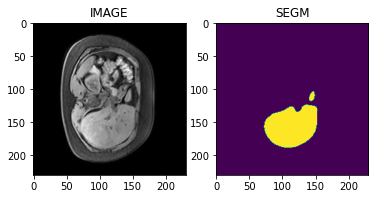

In [33]:
check_ds = monai.data.Dataset(data=external_test_data_dict[1:2], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=1, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['IMAGE'].shape)

num_display = 10
if check_data['IMAGE'].shape[0] < num_display:
    num_display = check_data['IMAGE'].shape[0]

for i in range(num_display):
    image, label = (check_data['IMAGE'][i][0], check_data['SEGM'][i][0])
    print('image shape: {}, label shape: {}'.format(image.shape, label.shape))
    print('image mean: {}'.format(np.mean(image.numpy())))

    slice_num = image.shape[2]//2
    
    plt.figure('check', (6, 3))
    plt.subplot(1, 2, 1)
    plt.title('IMAGE')
    plt.imshow(image[:,:,slice_num], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('SEGM')
    plt.imshow(label[:,:,slice_num])
    plt.show()

0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarni

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 182 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 182 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 183 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the 

0.90178382396698
7.878722189186193
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 47 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 48 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 49 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: t

0.9017976522445679
7.720827452344087
inf
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


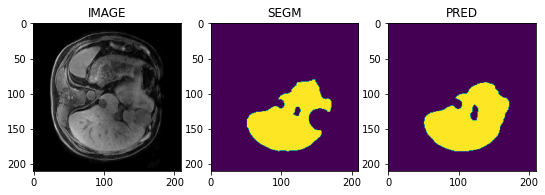

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 61 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 62 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 63 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 61 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 62 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 63 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarnin

0.9589182138442993
2.191167663676561
inf
0.9590303897857666
2.191167663676561
inf
torch.Size([1, 2, 230, 230, 125])
torch.Size([1, 230, 230, 125])


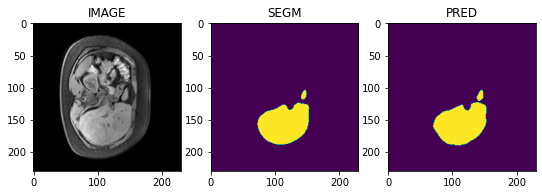

0.922211766242981
10.055392455318728
inf
0.9395979046821594
3.3321092076666865
inf
torch.Size([1, 2, 228, 228, 105])
torch.Size([1, 228, 228, 105])


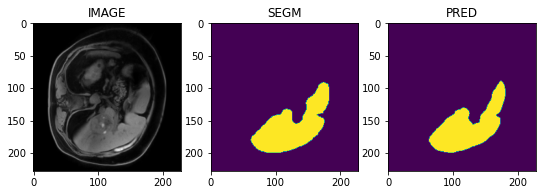

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 79 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 80 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 81 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarnin

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 79 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 80 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 81 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the p

0.9221127033233643
20.387405649509688
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 91 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 175 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 91 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the 

0.9354757070541382
4.448464020591648
inf
torch.Size([1, 2, 211, 211, 104])
torch.Size([1, 211, 211, 104])


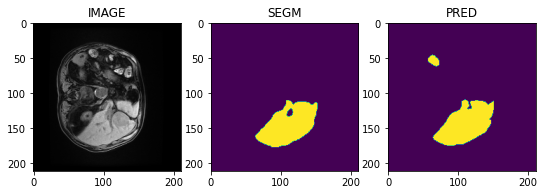

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 172 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 173 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 173 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Use

0.9304561614990234
11.19814318902783
inf
0.9319126009941101
3.761247562342417
inf
torch.Size([1, 2, 191, 167, 118])
torch.Size([1, 191, 167, 118])


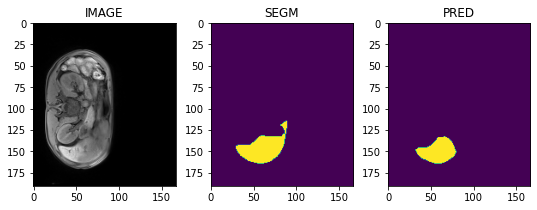

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 171 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 172 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 171 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWar

0.9207696914672852
23.086136400545794
inf
0.9380450248718262
4.983816978773101
inf
torch.Size([1, 2, 211, 211, 109])
torch.Size([1, 211, 211, 109])


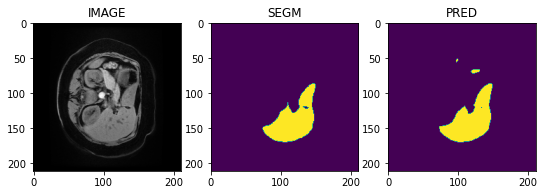

0.8959912061691284
7.308569573011596
inf
0.900986909866333
2.9762777774877844
inf
torch.Size([1, 2, 201, 178, 108])
torch.Size([1, 201, 178, 108])


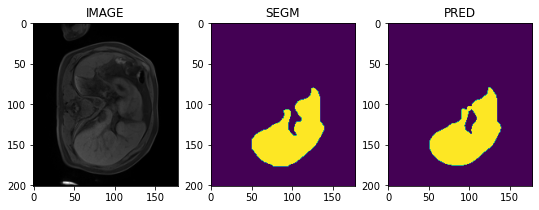

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 91 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 92 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 92 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWa

0.9370152950286865
3.534817498244742
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 96 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 96 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")


0.9370793104171753
3.02957017862394
inf
torch.Size([1, 2, 204, 204, 100])
torch.Size([1, 204, 204, 100])


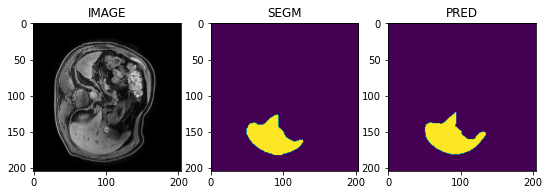

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 156 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 157 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 157 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Use

0.9057347178459167
4.962533212567209
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 162 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 163 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 164 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning

0.9057477712631226
4.35897349124107
inf
torch.Size([1, 2, 189, 189, 105])
torch.Size([1, 189, 189, 105])


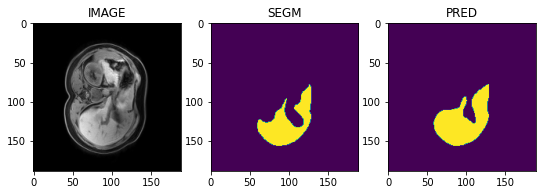

0.9508912563323975
3.6884407414869207
inf
0.951184868812561
1.9351907414869212
inf
torch.Size([1, 2, 201, 201, 96])
torch.Size([1, 201, 201, 96])


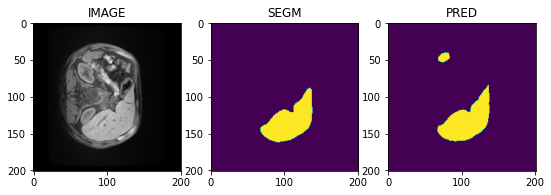

0.9049791097640991
22.59502577969123
inf
0.9493854641914368
2.164503295479979
inf
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


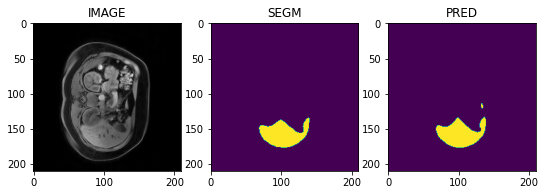

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 96 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 97 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 96 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarnin

0.9557009935379028
2.0417720526018703
inf
0.9559930562973022
1.9772860306930193
inf
torch.Size([1, 2, 210, 210, 110])
torch.Size([1, 210, 210, 110])


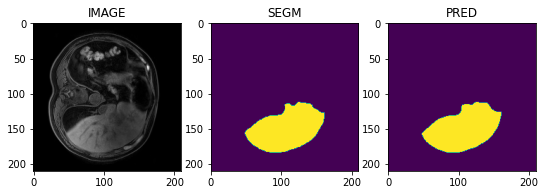

0.9648468494415283
3.137679871199899
inf
0.9649560451507568
1.874402359238184
inf
torch.Size([1, 2, 210, 210, 125])
torch.Size([1, 210, 210, 125])


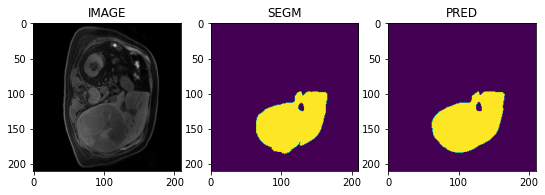

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 135 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 135 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 136 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 135 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 135 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 136 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning

0.9501779079437256
7.249969304772904
1.1519803980732886
0.9514264464378357
6.07628570899066
0.9489432075274185
torch.Size([1, 2, 172, 172, 100])
torch.Size([1, 172, 172, 100])


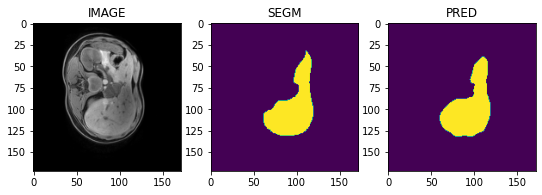

0.9561525583267212
4.858975733677393
inf
0.957187294960022
2.3819643429504684
0.6729225558908052
torch.Size([1, 2, 221, 221, 114])
torch.Size([1, 221, 221, 114])


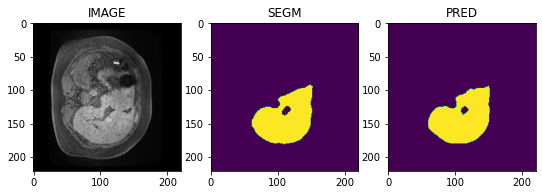

0.9261021018028259
10.669265159631513
inf
0.9283369779586792
3.7589913487162017
inf
torch.Size([1, 2, 207, 207, 105])
torch.Size([1, 207, 207, 105])


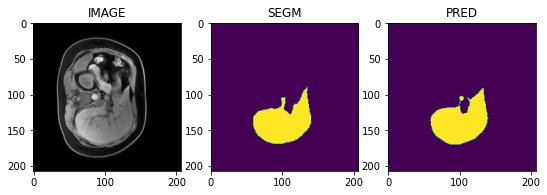

[0.90178382396698, 0.9589182138442993, 0.922211766242981, 0.9221127033233643, 0.9304561614990234, 0.9207696914672852, 0.8959912061691284, 0.9370152950286865, 0.9057347178459167, 0.9508912563323975, 0.9049791097640991, 0.9557009935379028, 0.9648468494415283, 0.9501779079437256, 0.9561525583267212, 0.9261021018028259]


,DICE,POST_DICE,HD95,POST_HD95,InferenceTime
count,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.931490,0.938009,9.052751,3.560692,0.007106
std,0.022573,0.020340,7.068519,1.654255,0.002991
min,0.895991,0.900987,2.041772,1.874402,0.004081
25%,0.917011,0.931019,3.650035,2.184502,0.004818
50%,0.928279,0.938821,7.279269,3.180840,0.005788
75%,0.952094,0.952568,10.801485,4.381346,0.009732
max,0.964847,0.964956,23.086136,7.720827,0.014341


In [34]:
roi_size = (224, 224, 128)

df_external_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= external_test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=False) #, max_eval = 2

torch.cuda.empty_cache()
df_external_test_results['EXPERIMENT_ID'] = 'PRE-Contrast-Imaging'
df_external_test_results.describe()

In [35]:
df_external_test_results.describe()

,DICE,POST_DICE,HD95,POST_HD95,InferenceTime
count,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.931490,0.938009,9.052751,3.560692,0.007106
std,0.022573,0.020340,7.068519,1.654255,0.002991
min,0.895991,0.900987,2.041772,1.874402,0.004081
25%,0.917011,0.931019,3.650035,2.184502,0.004818
50%,0.928279,0.938821,7.279269,3.180840,0.005788
75%,0.952094,0.952568,10.801485,4.381346,0.009732
max,0.964847,0.964956,23.086136,7.720827,0.014341


In [36]:
df_external_test_results.to_csv('ExternalTestingResults/Results-PRE-Net.csv')